In [63]:
%matplotlib inline

import numpy as np
import xarray as xr

from scipy.ndimage.measurements import center_of_mass

import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import LinearRing, MultiPoint, MultiPolygon

import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, RIVERS


scale = '50m'

plt.rcParams.update({'mathtext.default':  'regular' })

In [9]:
# projection class
class Rasm(ccrs.Projection):

    def __init__(self):

        proj4_params = {'R': 6371200.0,
                        'lat_0': 90.0,
                        'lat_1': 90,
                        'lat_2': 90,
                        'lon_0': -114.0+360,
                        'proj': 'lcc',
                        'units': 'm',
                        'x_0': 9469302.950316086,
                        'y_0': 6201952.603370549}

        super(Rasm, self).__init__(proj4_params)

    @property
    def boundary(self):
        coords = ((self.x_limits[0], self.y_limits[0]),(self.x_limits[1], self.y_limits[0]),
                  (self.x_limits[1], self.y_limits[1]),(self.x_limits[0], self.y_limits[1]),
                  (self.x_limits[0], self.y_limits[0]))

        return ccrs.sgeom.Polygon(coords).exterior

    @property
    def threshold(self):
        return 100000.0

    @property
    def x_limits(self):
        return (0, 16423961.103252266)

    @property
    def y_limits(self):
        return (0, 12228062.194885937)

In [10]:
wrf_vic_masks = xr.open_dataset('../../../data/inputdata/RASM_WRFVIC_GRID_MASKS_AND_METRICS.nc')
pop_cice_masks = xr.open_dataset('../../../data/inputdata/RASM_POPCICE_GRID_MASKS_AND_METRICS.nc')
wrf_rvic_masks = xr.open_dataset('../../../data/inputdata/RASM_VICRVIC_GRID_MASKS_AND_METRICS.nc')

wr50a_domain = xr.open_dataset('../../../data/inputdata/CESM/share/domains/domain.lnd.wr50a_ar9v4.130607.nc')
ar9_domain = xr.open_dataset('../../../data/inputdata/CESM/share/domains/domain.ocn.ar9v4.130325.nc')

dai_obs = xr.open_dataset('../../../data/compare/dai_trenberth_river/coastal-stns-Vol-monthly.updated-oct2007.nc', decode_times=False)

In [11]:
ocn_mask = pop_cice_masks[['mask_centralarctic', 'mask_bering', 'mask_okhotsk', 'mask_japan', 'mask_pacific',
                            'mask_kara', 'mask_barents', 'mask_norwegian', 'mask_greenland', 'mask_denmarkstrait', 
                            'mask_labrador', 'mask_baffin', 'mask_hudsonbay', 'mask_archipelago', 'mask_baltic' , 
                            'mask_northsea', 'mask_atlantic', 'mask_canada', 'mask_nansen', 'mask_shelf']].to_array().sum('variable')

In [13]:
y, x = np.nonzero(wrf_vic_masks['mask_greenland_island'].values)
mp = MultiPoint(list(zip(wrf_vic_masks['mask_greenland_island']['longitude'].values[y, x], wrf_vic_masks['mask_greenland_island']['latitude'].values[y, x])))
gl_hull = mp.convex_hull.simplify(3).exterior

In [14]:
y, x = np.nonzero(wrf_rvic_masks['mask_rvic_drainage'].values)
mp = MultiPoint(list(zip(wrf_rvic_masks['mask_rvic_drainage']['xc'].values[y, x], wrf_rvic_masks['mask_rvic_drainage']['yc'].values[y, x])))
rvic_hull = mp.convex_hull.exterior

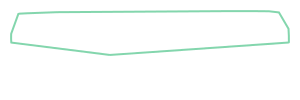

In [15]:
rvic_hull

In [18]:
ocean_depth = pop_cice_masks.HT / -100.
lnd_elev = wrf_vic_masks.HGT

In [87]:
levels = [-5000, -4000, -3000, -2000, -1000, -500, -250, 0, 250, 500, 1000, 2000, 3000, 4000, 5000]
# vmin=-6000, vmax=6000, 

In [88]:
shapes = {}
shapes['shelf'] = [(113.7366529006488, 78.03080727626906), (112.2718112672456, 70.18525638019177), (177.7978257335182, 62.06397064307408), (189.8743994667148, 68.2879161699658), (113.7366529006488, 78.03080727626906)]
shapes['canada'] = [(-121.7031868342398, 67.7215741706094), (-126.5650545731124, 74.4075477493822), (-171.2973325321617, 70.14396352414349), (-161.3230859583278, 64.4297855696157), (-121.7031868342398, 67.7215741706094)]
shapes['kara_barrents'] = [(36.06614093875805, 70.4126608318343), (53.92299694433034, 61.76281380910994), (110.3253911335403, 68.93837059743467), (112.5070729419679, 79.13748043666854), (36.06614093875805, 70.4126608318343)]

regions = {}
bounds = {}

domain = wr50a_domain

for key, s in shapes.items():
    poly = LinearRing(s)
    x0, y0, x1, y1 = poly.bounds
    bounds[key] = poly.bounds
    if x0 < 0:
        x0 += 360
    if x1 < 0:
        x1 += 360
        
    if x1 < x0:
        x1, x0 = x0, x1
        
        regions[key] = (~((domain.xc > x0) & (domain.xc < x1)) &
                        (domain.yc > y0) & (domain.yc < y1))
    else:
        regions[key] = ((domain.xc > x0) & (domain.xc < x1) &
                        (domain.yc > y0) & (domain.yc < y1))
        

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


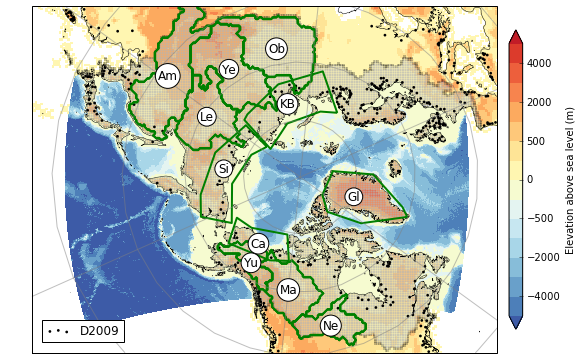

In [91]:
fig, ax = plt.subplots(figsize=(8.5, 5.5), subplot_kw=dict(projection=Rasm()))

lnd_elev.where(lnd_elev > 0).plot.pcolormesh('longitude', 'latitude', ax=ax, cmap='RdYlBu_r', levels=levels, transform=ccrs.PlateCarree(), add_colorbar=False, extend='both')
wrf_rvic_masks.mask_rvic_drainage.where(wrf_rvic_masks.mask_rvic_drainage > 0).plot.pcolormesh('xc', 'yc', ax=ax, cmap='gray', vmin=0, vmax=1.4, transform=ccrs.PlateCarree(), add_colorbar=False, alpha=0.25)
mappable = ocean_depth.where(ocn_mask > 0).plot.pcolormesh('longitude', 'latitude', ax=ax, cmap='RdYlBu_r', levels=levels, transform=ccrs.PlateCarree(), add_colorbar=False, extend='both')

ax.coastlines(resolution='50m', lw=0.5, color='k')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='-')

river_masks = ['mask_amur','mask_ob','mask_yenisey','mask_lena','mask_mackenzie','mask_nelson','mask_yukon']
labels = ['Am', 'Ob', 'Ye', 'Le', 'Ma', 'Ne', 'Yu']

for r, c, l in zip(river_masks, river_colors, labels):
    da = (wrf_rvic_masks[r] > 0.5)
    da.plot.contour('xc', 'yc', ax=ax, colors='green', transform=ccrs.PlateCarree(), add_colorbar=False, lw=0.7)
    x, y = map(int, center_of_mass(da.values))
    lon = da.xc.isel(ni=y, nj=x)
    lat = da.yc.isel(ni=y, nj=x)
    at_x, at_y = ax.projection.transform_point(lon, lat,
                                               src_crs=ccrs.PlateCarree())
    
    bbox_props = dict(boxstyle="circle,pad=0.2", fc="white", ec="k", lw=1)
    t = ax.text(at_x, at_y, l, ha="center", va="center", rotation=0,
            size=12,
            bbox=bbox_props)
    
ax.scatter(dai_obs.lon, dai_obs.lat, transform=ccrs.PlateCarree(),
           marker='.', facecolor='k', edgecolor='none', s=30,
           label='D2009')

coast_masks = ['shelf', 'canada', 'kara_barrents']

labels = ['Si', 'Ca', 'KB']
for i, key in enumerate(coast_masks):
    l = labels[i]
    poly = LinearRing(shapes[key])
    ax.add_geometries([poly], ccrs.PlateCarree(),
                  facecolor='none', edgecolor='green', lw=2)
    x, y = poly.centroid.coords.xy
    lon, lat = x[0], y[0]
    at_x, at_y = ax.projection.transform_point(lon, lat,
                                               src_crs=ccrs.PlateCarree())
    
    bbox_props = dict(boxstyle="circle,pad=0.2", fc="white", ec="k", lw=1)
    t = ax.text(at_x, at_y, l, ha="center", va="center", rotation=0,
            size=12,
            bbox=bbox_props)

ax.add_geometries([gl_hull], ccrs.PlateCarree(),
                  facecolor='none', edgecolor='green', lw=2)

x, y = gl_hull.centroid.coords.xy
lon, lat = x[0], y[0]
at_x, at_y = ax.projection.transform_point(lon, lat,
                                           src_crs=ccrs.PlateCarree())

bbox_props = dict(boxstyle="circle,pad=0.2", fc="white", ec="k", lw=1)
t = ax.text(at_x, at_y, 'Gl', ha="center", va="center", rotation=0,
        size=12,
        bbox=bbox_props)

cbar = plt.colorbar(mappable=mappable, orientation='vertical', shrink=0.8, pad=0.02)

cbar.set_label('Elevation above sea level (m)')

ax.legend(loc=(0.07, 0.03))

fig.tight_layout()

fig.savefig('../figs/RASM_domain_fig.png', dpi=300)